# ACLED National and Subnational Conflict Trends

In [5]:
%reload_ext autoreload
%autoreload 2

import os

from acled_conflict_analysis import visuals
from acled_conflict_analysis import processing
from acled_conflict_analysis import extraction


from bokeh.plotting import show, output_notebook
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs, TabPanel

from datetime import date
from datetime import datetime


In [6]:
def create_comparative_maps(data, title, measures=None, aggregation='h3', 
                           categories=None, cmaps=None, plot_type='color',
                           boundary_gdf=None, figsize=(15, 5), color_dict=None):
    """
    Creates comparative maps based on specified measures, aggregation levels, and categories.
    
    Parameters:
    -----------
    data : GeoDataFrame
        The spatial data to plot
    title : str
        The title for the figure
    measures : str, list, or dict
        - If str: single measure to plot
        - If list: multiple measures to plot with different colors
        - If dict: {measure_name: {options}} for advanced configuration
    aggregation : str
        Type of spatial aggregation: 'h3', 'latlon', or 'admin'
    categories : list or None
        List of category values to create separate maps for (e.g., time periods)
        If None, no category separation is applied
    cmaps : str, list, or dict
        Color maps to use for different measures:
        - If str: single colormap for all measures
        - If list: list of colormaps matching measures list
        - If dict: {measure_name: colormap} for specific mapping
    plot_type : str
        'color' for choropleth maps with quartiles
        'size' for bubble maps where size indicates value
        'both' for maps with both size and color coding
    boundary_gdf : GeoDataFrame or None
        GeoDataFrame containing boundary lines to plot (e.g., country borders)
    figsize : tuple
        Figure size as (width, height)
    color_dict : dict or None
        User-defined colors for specific measures, e.g., {'nrEvents': 'Blues', 'custom_measure': 'Greens'}
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    from matplotlib.colors import Normalize
    from datetime import datetime

    font_choice = 'Arial'
    
    # Default values
    if measures is None:
        measures = data.select_dtypes(include=np.number).columns[0]
    
    # Convert measures to standardized format (always a dictionary)
    if isinstance(measures, str):
        measures = {measures: {}}
    elif isinstance(measures, list):
        measures = {m: {} for m in measures}
    
    # Set default categories if none provided (single map)
    if categories is None:
        categories = ['All Data']
        if 'category' not in data.columns:
            data['category'] = 'All Data'
    
    # Set up default colormaps
    default_cmaps = {
        'nrEvents': 'Blues',
        'nrFatalities': 'Reds',
    }
    
    # Process user-provided color dict (overrides the defaults)
    if color_dict is not None:
        default_cmaps.update(color_dict)
    
    # Set up measure-specific options
    for measure_name in measures.keys():
        # Set default colormap if not specified
        if 'cmap' not in measures[measure_name]:
            if cmaps is not None:
                if isinstance(cmaps, str):
                    measures[measure_name]['cmap'] = cmaps
                elif isinstance(cmaps, list) and len(cmaps) == len(measures):
                    measures[measure_name]['cmap'] = cmaps[list(measures.keys()).index(measure_name)]
                elif isinstance(cmaps, dict) and measure_name in cmaps:
                    measures[measure_name]['cmap'] = cmaps[measure_name]
                else:
                    # Use default from color_dict, fall back to default_cmaps, or use 'Purples' as the fallback
                    measures[measure_name]['cmap'] = default_cmaps.get(measure_name, 'Purples')
            else:
                measures[measure_name]['cmap'] = default_cmaps.get(measure_name, 'Purples')
        
        # Set default alpha if not specified
        if 'alpha' not in measures[measure_name]:
            measures[measure_name]['alpha'] = 0.7
        
        # Set default size factor for sizes - adjusted for better scaling
        if 'size_factor' not in measures[measure_name]:
            # Default size factor depends on the plot type and data characteristics
            if plot_type == 'size' or plot_type == 'both':
                measures[measure_name]['size_factor'] = 100  # Base factor, will be scaled by data range later
            else:
                measures[measure_name]['size_factor'] = 5
                
        # Set default label name if not specified
        if 'label_name' not in measures[measure_name]:
            measures[measure_name]['label_name'] = measure_name
    
    # Create figure and axes with gridspec for equal distribution
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, len(categories), wspace=0.05, hspace=0.05)
    axes = []
    
    # Create axes with equal size and distribution
    for i in range(len(categories)):
        axes.append(fig.add_subplot(gs[0, i]))
        # Immediately disable all ticks and spines for each subplot
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        axes[i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        for spine in axes[i].spines.values():
            spine.set_visible(False)
        
    # Handle single subplot case
    if len(categories) == 1:
        axes = [axes[0]]
    
    # Create a deep copy of the dataframe to avoid SettingWithCopyWarning
    plot_data = data.copy(deep=True)
    
    # Process each measure for quartiles if using color mapping
    if plot_type in ['color', 'both']:
        for measure_name in measures.keys():
            # Filter out NaN values for calculations
            non_nan_data = plot_data[plot_data[measure_name].notna()]
            
            if len(non_nan_data) == 0:
                print(f"Warning: No valid data for measure '{measure_name}'")
                continue
                
            try:
                # Calculate quantiles for 4 equal-sized groups
                q_values = [0, 0.25, 0.5, 0.75, 1.0]
                quantiles = non_nan_data[measure_name].quantile(q_values).tolist()
                
                # Handle the case where there are duplicate values at quantile boundaries
                unique_quantiles = []
                for q in quantiles:
                    if q not in unique_quantiles:
                        unique_quantiles.append(q)
                        
                # If all values are the same, add a small increment to create distinctions
                if len(unique_quantiles) == 1:
                    epsilon = 1e-10
                    unique_quantiles = [unique_quantiles[0] - epsilon, 
                                       unique_quantiles[0],
                                       unique_quantiles[0] + epsilon,
                                       unique_quantiles[0] + 2*epsilon,
                                       unique_quantiles[0] + 3*epsilon]
                                       
                # If we have fewer than 5 edges (needed for 4 bins), add intermediates
                while len(unique_quantiles) < 5:
                    for i in range(len(unique_quantiles)-1):
                        mid = (unique_quantiles[i] + unique_quantiles[i+1]) / 2
                        if mid not in unique_quantiles:
                            unique_quantiles.insert(i+1, mid)
                            break
                    
                # Ensure we have exactly 5 quantiles for 4 bins
                unique_quantiles = sorted(unique_quantiles[:5])
                
                # Create quartile categories using pd.cut() with our manual bins
                quartile_col = f"{measure_name}_quartile"
                quartile_categories = pd.cut(
                    plot_data[measure_name],
                    bins=unique_quantiles,
                    labels=['Q1', 'Q2', 'Q3', 'Q4'],
                    include_lowest=True
                )
                
                # Store the bin edges for the legend
                measures[measure_name]['bin_edges'] = unique_quantiles
                
            except (ValueError, IndexError) as e:
                print(f"Warning: Issue computing quartiles for {measure_name}: {e}")
                # Fallback to hardcoded bins if we still have issues
                min_val = non_nan_data[measure_name].min()
                max_val = non_nan_data[measure_name].max()
                step = (max_val - min_val) / 4
                
                # Create evenly spaced bins
                bin_edges = [min_val + i * step for i in range(5)]
                if bin_edges[0] == bin_edges[1]:  # Avoid duplicate lower bound
                    bin_edges[0] -= 0.0001
                    
                # Create quartile categories
                quartile_col = f"{measure_name}_quartile"
                quartile_categories = pd.cut(
                    plot_data[measure_name],
                    bins=bin_edges,
                    labels=['Q1', 'Q2', 'Q3', 'Q4'],
                    include_lowest=True
                )
                
                # Store bin edges
                measures[measure_name]['bin_edges'] = bin_edges
            
            # Convert to string to avoid dtype incompatibility
            plot_data[quartile_col] = quartile_categories.astype(str)
    
    # Find global min and max for each measure for consistent sizing/coloring
    for measure_name in measures.keys():
        non_nan_data = plot_data[plot_data[measure_name].notna()]
        
        if len(non_nan_data) > 0:
            min_val = non_nan_data[measure_name].min()
            max_val = non_nan_data[measure_name].max()
            data_range = max_val - min_val
            
            measures[measure_name]['vmin'] = min_val
            measures[measure_name]['vmax'] = max_val
            
            # Adjust size_factor based on data range
            if plot_type in ['size', 'both']:
                # Scale size factor based on the data range to ensure consistent visuals
                # For smaller ranges, use larger factors; for larger ranges, use smaller factors
                if data_range > 0:
                    base_size = measures[measure_name]['size_factor']
                    
                    if aggregation == 'h3':
                        # H3 cells are polygons, so we use a different sizing approach
                        measures[measure_name]['size_factor'] = base_size / (10 * np.log10(data_range + 1))
                    else:
                        # For point data, scale inversely with the data range
                        measures[measure_name]['size_factor'] = base_size / np.sqrt(data_range)
                else:
                    # If all values are the same, use a fixed size
                    measures[measure_name]['size_factor'] = 10
        else:
            print(f"Warning: No valid data for measure '{measure_name}'")
            measures[measure_name]['vmin'] = 0
            measures[measure_name]['vmax'] = 1
    
    # Plot each category
    for idx, category in enumerate(categories):
        ax = axes[idx]
        
        # Ensure all spines are hidden for all plots
        for spine in ax.spines.values():
            spine.set_visible(False)
            
        # Plot boundary if provided
        if boundary_gdf is not None:
            boundary_gdf.boundary.plot(ax=ax, color='lightgrey', alpha=0.7, linewidth=1)
        
        # Filter data for this category
        if category != 'All Data' or 'category' in plot_data.columns:
            category_data = plot_data[plot_data['category'] == category]
        else:
            category_data = plot_data
        
        # Plot each measure according to the specified plot type
        for i, (measure_name, measure_opts) in enumerate(measures.items()):
            vmin = measure_opts['vmin']
            vmax = measure_opts['vmax']
            cmap = measure_opts['cmap']
            alpha = measure_opts['alpha']
            size_factor = measure_opts['size_factor']
            label_name = measure_opts.get('label_name', measure_name)
            
            # Skip if no data (prevents empty plots)
            if len(category_data) == 0 or not category_data[measure_name].notna().any():
                continue
            
            if plot_type == 'color' or (plot_type == 'both' and aggregation == 'h3'):
                # Plot with choropleth colors based on quartiles
                quartile_col = f"{measure_name}_quartile"
                category_data.plot(
                    ax=ax,
                    column=quartile_col,
                    categorical=True,
                    cmap=cmap,
                    alpha=alpha,
                    legend=False
                )
                
            elif plot_type == 'size' or (plot_type == 'both' and aggregation in ['latlon', 'admin']):
                # Use a more controlled approach to sizing that works better with outliers
                # Apply a log-based transformation to handle large value ranges
                if vmin < vmax:  # Only if we have a valid range
                    # Add a small constant to handle zeros
                    epsilon = (vmax - vmin) * 0.01 if vmax > vmin else 0.1
                    
                    # Get log-transformed values
                    log_vals = np.log1p((category_data[measure_name] - vmin) + epsilon)
                    log_max = np.log1p((vmax - vmin) + epsilon)
                    
                    # Scale to a reasonable marker size range (3 to 15)
                    sizes = 3 + (log_vals / log_max) * 12
                else:
                    # Fallback for when all values are the same
                    sizes = np.ones(len(category_data)) * 5
                
                # Plot with bubble sizes
                category_data.plot(
                    ax=ax,
                    color=plt.cm.get_cmap(cmap)(0.6),  # Use a fixed color from the colormap
                    alpha=alpha,
                    markersize=sizes
                )
                
            elif plot_type == 'both':
                # Both size and color for a single measure
                # Create a normalized color mapping based on values
                norm = Normalize(vmin=vmin, vmax=vmax)
                
                # For combined plots, we need to handle sizing better
                if hasattr(category_data.geometry.iloc[0], 'centroid'):
                    # For polygon data (like H3 cells), we'll plot centroids with sized markers
                    for _, row in category_data.iterrows():
                        if pd.notna(row[measure_name]):
                            value = row[measure_name]
                            normalized_value = (value - vmin) / (vmax - vmin + 1e-10)
                            color = plt.cm.get_cmap(cmap)(normalized_value)
                            
                            # Get the centroid for the marker placement
                            centroid = row.geometry.centroid
                            
                            # Apply log-based sizing for better distribution of sizes
                            epsilon = (vmax - vmin) * 0.01 if vmax > vmin else 0.1
                            log_val = np.log1p((value - vmin) + epsilon)
                            log_max = np.log1p((vmax - vmin) + epsilon)
                            marker_size = 3 + (log_val / log_max) * 12
                            
                            ax.plot(
                                centroid.x, centroid.y,
                                'o',
                                color=color,
                                alpha=alpha,
                                markersize=marker_size
                            )
                else:
                    # For point data, use direct plotting with sized markers
                    for _, row in category_data.iterrows():
                        if pd.notna(row[measure_name]):
                            value = row[measure_name]
                            normalized_value = (value - vmin) / (vmax - vmin + 1e-10)
                            color = plt.cm.get_cmap(cmap)(normalized_value)
                            
                            # Apply log-based sizing for better distribution of sizes
                            epsilon = (vmax - vmin) * 0.01 if vmax > vmin else 0.1
                            log_val = np.log1p((value - vmin) + epsilon)
                            log_max = np.log1p((vmax - vmin) + epsilon)
                            marker_size = 3 + (log_val / log_max) * 12
                            
                            ax.plot(
                                row.geometry.x, row.geometry.y,
                                'o',
                                color=color,
                                alpha=alpha,
                                markersize=marker_size
                            )
        
        # Add legend on the last subplot
        if idx == len(categories) - 1:
            legend_items = []
            
            for measure_name, measure_opts in measures.items():
                if plot_type == 'color' or (plot_type == 'both' and aggregation == 'h3'):
                    # Create color legend for quartiles
                    cmap = plt.cm.get_cmap(measure_opts['cmap'])
                    colors = cmap(np.linspace(0.2, 0.8, 4))
                    
                    # Check if bin_edges exists
                    if 'bin_edges' in measure_opts:
                        bin_edges = measure_opts['bin_edges']
                        
                        for i in range(4):
                            if i < len(bin_edges) - 1:  # Ensure we have enough bin edges
                                legend_items.append(
                                    Patch(
                                        facecolor=colors[i],
                                        edgecolor='none',
                                        alpha=measure_opts['alpha'],
                                        label=f"{label_name} Q{i+1} ({bin_edges[i]:.2f}-{bin_edges[i+1]:.2f})"
                                    )
                                )
                
                if plot_type == 'size' or (plot_type == 'both' and aggregation != 'h3'):
                    # Create size legend with better size representation
                    vmin = measure_opts['vmin']
                    vmax = measure_opts['vmax']
                    
                    # Create evenly spaced values between min and max for a better legend
                    size_values = np.linspace(vmin, vmax, 4)
                    size_labels = [f"{measure_name}: {val:.2f}" for val in size_values]
                    
                    # Calculate marker sizes consistently with the plotting approach
                    epsilon = (vmax - vmin) * 0.01 if vmax > vmin else 0.1
                    log_values = [np.log1p((val - vmin) + epsilon) for val in size_values]
                    log_max = np.log1p((vmax - vmin) + epsilon)
                    marker_sizes = [3 + (log_val / log_max) * 12 for log_val in log_values]
                    
                    for ms, label in zip(marker_sizes, size_labels):
                        legend_items.append(
                            Line2D(
                                [0], [0],
                                marker='o',
                                color='w',
                                markerfacecolor=plt.cm.get_cmap(measure_opts['cmap'])(0.6),
                                markersize=ms,
                                alpha=measure_opts['alpha'],
                                label=label
                            )
                        )

        # Set title and clean up axes - position the title at the top
        ax.set_title(category, y=1.0, pad=10, fontfamily=font_choice)
        
        # Ensure all ticks and spines are completely removed
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(left=False, right=False, bottom=False, top=False,
                    labelleft=False, labelright=False, labelbottom=False, labeltop=False)
        
        # Hide all spines
        for spine in ax.spines.values():
            spine.set_visible(False)
    
            
    # Add legend with appropriate positioning
    if legend_items:
        legend_cols = min(4, len(legend_items))
        # Place legend at the bottom of the figure
        legend = fig.legend(
            handles=legend_items,
            loc='lower center',
            frameon=False,
            ncol=legend_cols,
            bbox_to_anchor=(0.5, 0.12)  # Moved up slightly to make room for source text
        )
        
    # Set main title
    fig.suptitle(title, fontsize=16, y=0.95, fontfamily = font_choice, fontweight='bold')
    
    # Add source text box at the bottom
    today = datetime.now().strftime("%B %d, %Y")
    source_text = f"Source: ACLED. Accessed: {today}"
    fig.text(0.3, 0.02, source_text, ha='center', fontsize=9, fontfamily=font_choice
             )
    
    # Adjust layout to ensure equal spacing and size
    # Leave more space at bottom for legend and source text
    plt.subplots_adjust(bottom=0.25, top=0.85, wspace=0.05)
    
    return fig, axes

In [7]:
countries_of_interest = ["Ethiopia"]
START_DATE = "2012-01-01"
END_DATE = datetime.today().strftime('%Y-%m-%d')

In [8]:
os.environ['ACLED_EMAIL'] = extraction.get_acled_credentials()[0]
os.environ['ACLED_KEY'] = extraction.get_acled_credentials()[1]

In [9]:
data = extraction.acled_api(
    email_address=os.environ.get("ACLED_EMAIL"),
    access_key=os.environ.get("ACLED_KEY"),
    countries=countries_of_interest,
    start_date=START_DATE,
    end_date=END_DATE
)


c:\WBG\Anaconda3\envs\acled\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.acleddata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [10]:
extracted_date = datetime.today().strftime('%Y%m%d')
processing.data_type_conversion(data)

In [11]:
data.to_csv(f'../../data/conflict/acled_raw_{extracted_date}.csv')

In [12]:
conflict_monthly = processing.get_acled_by_group(data, columns=['latitude', 'longitude'], freq='MS')
conflict_yearly = processing.get_acled_by_group(data, columns=['latitude', 'longitude'], freq='YS')
conflict_yearly_national = processing.get_acled_by_group(data, columns=['country'], freq='YS')
conflict_sub_event_type = processing.get_acled_by_group(data, columns = ['event_type', 'sub_event_type'], freq='MS')
conflict_event_type = processing.get_acled_by_group(data, columns = ['country','event_type'], freq='MS')

In [13]:
events_dict = {datetime(2020, 11, 2):'Start of the Tigray War',
    datetime(2022, 11, 22):'Peace Agreement between \n  Ethiopia and TPLF',
    datetime(2019,6,22 ):'Coup Attempt in Amhara',
               }

In [14]:
# output_file("bokeh_plot.html")
output_notebook()


tabs = []
labels = {"nrFatalities": "Number of Fatalities","nrEvents": "Number of Events"}

for idx, type in enumerate(["nrFatalities", "nrEvents"]):
    tabs.append(
        TabPanel(
            child=visuals.get_line_plot(
                conflict_yearly_national,
                f"National Trends in {labels[type]}",
                "Source: ACLED. Accessed 10th April 2025",
                subtitle="",
                category="country",
                measure=type,
                #events_dict = events_dict
            ),
            title=type.capitalize(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

## Spatial Distribution of Conflict

In [15]:
import geopandas as gpd
ethiopia_adm0 = gpd.read_file('../../data/boundaries/eth_admbnda_adm0_csa_bofedb_itos_2021.shp')
eth_h3 = processing.convert_to_h3_grid(ethiopia_adm0, resolution=5)

In [16]:
import pandas as pd
from datetime import datetime

def get_category(event_date):
    """
    Categorize events based on date ranges.
    
    Parameters:
    -----------
    event_date : datetime, pandas.Timestamp, or str
        The date of the event
        
    Returns:
    --------
    str
        The category of the event based on the date
    """
    # Convert string date to pandas Timestamp if it's not already
    if isinstance(event_date, str):
        event_date = pd.Timestamp(event_date)
    # Convert datetime to pandas Timestamp if it's not already
    elif isinstance(event_date, datetime):
        event_date = pd.Timestamp(event_date)
    
    # Make sure event_date is a pandas Timestamp
    if not isinstance(event_date, pd.Timestamp):
        raise TypeError("event_date must be a datetime, pandas.Timestamp, or string date")
    
    # Define the date range boundaries
    tigray_start = pd.Timestamp('2020-11-03')
    tigray_end = pd.Timestamp('2022-11-03')
    amhara_start = pd.Timestamp('2023-04-01')
    
    # Compare using proper timestamp comparison
    if tigray_start <= event_date <= tigray_end:
        return 'Tigray War (3rd Nov 2020 - 3rd Nov 2022)'
    elif event_date > amhara_start:
        return 'Amhara War (1st Apr 2023 - Present)'

In [17]:
category_list = ['Tigray War (3rd Nov 2020 - 3rd Nov 2022)', 'Amhara War (1st Apr 2023 - Present)']

In [18]:
data['category'] = data['event_date'].apply(lambda x: get_category(x))
df = data[~(data['category'].isna())]

In [19]:
import numpy as np
conflict_monthly_h3 = processing.get_acled_by_admin(eth_h3, df, columns=['h3_index', 'category'], freq='MS', fatalities='fatalities')
conflict_monthly_h3.drop(columns=['index'], inplace=True)

conflict_monthly_h3['conflict_intensity_index_op1'] = np.sqrt((conflict_monthly_h3['nrEvents']) * 
                                           (conflict_monthly_h3['nrFatalities'] + 1))

conflict_monthly_h3 = conflict_monthly_h3.groupby(['h3_index', 'category'])[['nrEvents', 'nrFatalities', 'conflict_intensity_index_op1']].mean().reset_index()
conflict_monthly_h3 = eth_h3.merge(conflict_monthly_h3, on='h3_index', how='inner')

In [20]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_h3_maps(daily_mean, title, measure='nrEvents'):
    """
    Plot H3 grids with color representing the specified measure divided into quartiles
    
    Parameters:
    -----------
    daily_mean : GeoDataFrame
        The data to plot
    title : str
        The title for the figure
    measure : str
        The measure to plot on color scale (can be any numeric column)
    """
    # Set up the figure
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    
    # Choose colormap based on measure
    if measure == 'nrEvents':
        cmap = 'Blues' 
    elif measure =='nrFatalities':
        cmap = 'Reds'
    else:
        cmap = 'Purples'
    
    # Create a deep copy of the dataframe to avoid the SettingWithCopyWarning
    plot_data = daily_mean.copy(deep=True)
    
    # Filter out NaN values for calculations
    non_nan_data = plot_data[plot_data[measure].notna()]
    
    # Get min and max for legend
    vmin = non_nan_data[measure].min()
    vmax = non_nan_data[measure].max()
    
    # Manually create 4 equal-sized groups
    try:
        # Try to create exactly 4 equal-sized groups
        # First, calculate the quantiles
        q_values = [0, 0.25, 0.5, 0.75, 1.0]
        quantiles = non_nan_data[measure].quantile(q_values).tolist()
        
        # Handle the case where there are duplicate values at quantile boundaries
        unique_quantiles = []
        for q in quantiles:
            if q not in unique_quantiles:
                unique_quantiles.append(q)
                
        # If all values are the same, add a small increment to create distinctions
        if len(unique_quantiles) == 1:
            epsilon = 1e-10
            unique_quantiles = [unique_quantiles[0] - epsilon, 
                               unique_quantiles[0],
                               unique_quantiles[0] + epsilon,
                               unique_quantiles[0] + 2*epsilon,
                               unique_quantiles[0] + 3*epsilon]
                               
        # If we have fewer than 5 edges (needed for 4 bins), add intermediates
        while len(unique_quantiles) < 5:
            for i in range(len(unique_quantiles)-1):
                mid = (unique_quantiles[i] + unique_quantiles[i+1]) / 2
                if mid not in unique_quantiles:
                    unique_quantiles.insert(i+1, mid)
                    break
            
        # Ensure we have exactly 5 quantiles for 4 bins
        unique_quantiles = unique_quantiles[:5]
        
        # Create quartile categories using pd.cut() with our manual bins
        quartile_categories = pd.cut(
            plot_data[measure],
            bins=unique_quantiles,
            labels=['Q1', 'Q2', 'Q3', 'Q4'],
            include_lowest=True
        )
        
        # Store the bin edges for the legend
        bin_edges = unique_quantiles
        
    except (ValueError, IndexError):
        # Fallback to hardcoded bins if we still have issues
        min_val = non_nan_data[measure].min()
        max_val = non_nan_data[measure].max()
        step = (max_val - min_val) / 4
        
        # Create evenly spaced bins
        bin_edges = [min_val + i * step for i in range(5)]
        if bin_edges[0] == bin_edges[1]:  # Avoid duplicate lower bound
            bin_edges[0] -= 0.0001
            
        # Create quartile categories
        quartile_categories = pd.cut(
            plot_data[measure],
            bins=bin_edges,
            labels=['Q1', 'Q2', 'Q3', 'Q4'],
            include_lowest=True
        )
    
    # Convert to string to avoid dtype incompatibility
    plot_data = plot_data.assign(quartile=quartile_categories.astype(str))
    
    for idx, period in enumerate(['Tigray War', 'Amhara War']):
        # Plot Syria boundary (only if ethiopia_adm1_gadm is defined and available)
        try:
            ethiopia_adm1_gadm.boundary.plot(ax=ax[idx], color='lightgrey', alpha=0.9, linewidth=1)
        except NameError:
            # If the ethiopia_adm1_gadm is not defined, skip plotting it
            pass
        
        # Filter data for the current period
        period_data = plot_data[plot_data['category'] == period]
        
        # Check if there's any data for this period
        if period_data.empty:
            ax[idx].text(0.5, 0.5, f"No data for {period}", 
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax[idx].transAxes)
            continue
            
        # Fix: Set aspect to 'auto' to avoid aspect ratio problems
        ax[idx].set_aspect('auto')
        
        # Plot the data with discrete colors based on quartiles
        try:
            period_data.plot(
                ax=ax[idx], 
                column='quartile',  # Use the quartile column
                categorical=True,
                cmap=cmap, 
                alpha=0.9,
                markersize=8,  # Fixed marker size
                legend=False
            )
        except ValueError as e:
            # If plotting fails with the aspect error, try an alternative method
            print(f"Error while plotting {period}: {e}")
            # Plot without specifying aspects
            for quartile, group in period_data.groupby('quartile'):
                color_idx = ['Q1', 'Q2', 'Q3', 'Q4'].index(quartile)
                color = plt.colormaps[cmap](np.linspace(0.2, 0.8, 4))[color_idx]
                group.plot(ax=ax[idx], color=color, alpha=0.7, markersize=8)
        
        # Set title and remove spines/ticks
        ax[idx].set_title(period)
        ax[idx].spines['top'].set_visible(False)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].spines['bottom'].set_visible(False)
        ax[idx].spines['left'].set_visible(False)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
    
    # Create a custom legend
    from matplotlib.patches import Patch
    colors = plt.colormaps[cmap](np.linspace(0.2, 0.8, 4))  # Always 4 colors
    
    # Create legend elements for exactly 4 quartiles
    legend_elements = []
    for i in range(4):
        legend_elements.append(
            Patch(
                facecolor=colors[i], 
                edgecolor='none', 
                alpha=0.7, 
                label=f'Q{i+1} ({bin_edges[i]:.2f}-{bin_edges[i+1]:.2f})'
            )
        )
    
    # Add legend to the figure
    fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.01))
    
    plt.suptitle(title, fontsize=16)
    
    # No need for constrained_layout or tight_layout if it causes issues
    # Instead, adjust the figure to make room for the legend
    plt.subplots_adjust(bottom=0.2)
    
    return fig, ax

In [21]:
import geopandas as gpd 

ethiopia_adm1_gadm = gpd.read_file('../../data/boundaries/gadm/ETH_GADM_level1.shp')
ethiopia_adm2_gadm = gpd.read_file('../../data/boundaries/gadm/ETH_GADM_level2.shp')

C:\Users\wb588851\AppData\Local\Temp\ipykernel_23292\978774693.py:375: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(measure_opts['cmap'])


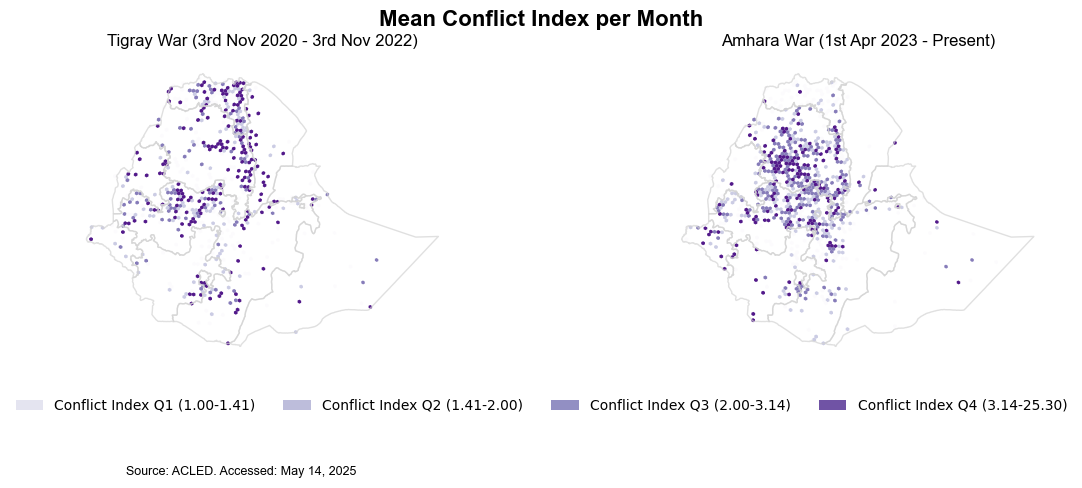

In [24]:
fig, ax = create_comparative_maps(conflict_monthly_h3, 
                                title='Mean Conflict Index per Month',
                                measures={'conflict_intensity_index_op1': {'label_name':'Conflict Index', 'alpha':0.9}},
                                aggregation='h3',
                                categories=category_list,
                                boundary_gdf=ethiopia_adm1_gadm,
                               figsize=(15,5)
                                )

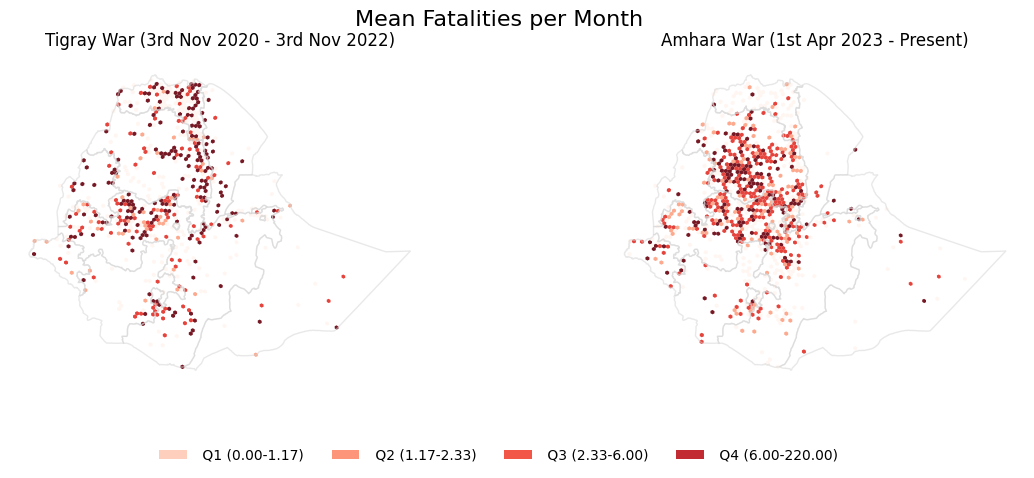

In [25]:
fig, ax = visuals.create_comparative_maps(conflict_monthly_h3, 
                                title='Mean Fatalities per Month',
                                measures={'nrFatalities': {'label_name':'', 'alpha':0.9}},
                                aggregation='h3',
                                categories=category_list,
                                boundary_gdf=ethiopia_adm1_gadm,
                               figsize=(15,5)
                                )

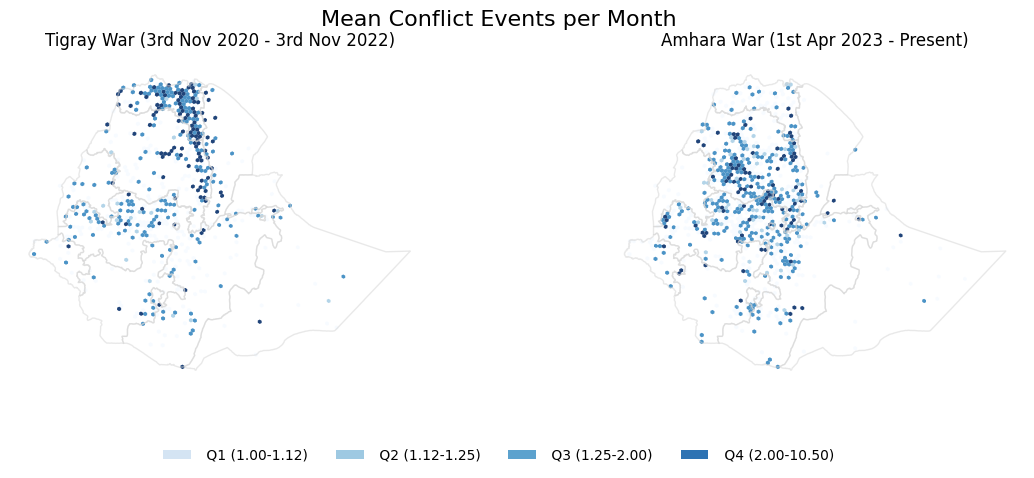

In [26]:
fig, ax = visuals.create_comparative_maps(conflict_monthly_h3, 
                                title='Mean Conflict Events per Month',
                                measures={'nrEvents': {'label_name':'', 'alpha':0.9}},
                                aggregation='h3',
                                categories=category_list,
                                boundary_gdf=ethiopia_adm1_gadm,
                               figsize=(15,5)
                                )

In [ ]:
data.rename(columns={'fatalities':'nrFatalities'}, inplace=True)

In [ ]:
from bokeh.plotting import show, output_notebook
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs

output_notebook()

bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

measure_names = {
    "nrEvents": "Number of Conflict Events",
    "nrFatalities": "Number of Fatalities",
}
measure_colors = {"nrEvents": "#4E79A7", "nrFatalities": "#F28E2B"}

measure = 'nrFatalities'

show(
    visuals.get_bar_chart(
        conflict_monthly,
        f"Monthly Reported {measure_names[measure]}",
        f"Source: ACLED. Accessed date {datetime.today().date().isoformat()}",
        subtitle="",
        category=None,
        measure=measure,
        color_code=measure_colors[measure],
        events_dict=events_dict
    )
)

Loading BokehJS ...

In [ ]:
from bokeh.plotting import show, output_notebook
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs, TabPanel

output_notebook()

bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)


tabs = []
measure_names = {
    "nrEvents": "Number of Conflict Events",
    "nrFatalities": "Number of Fatalities",
}
measure_colors = {"nrEvents": "#4E79A7", "nrFatalities": "#F28E2B"}
# acled_adm0 = get_acled_by_admin(syria_adm2_crs, acled, columns = ['ADM2_EN', 'ADM1_EN'])
for category_type in list(conflict_event_type["event_type"].unique()):
    tabs.append(
        TabPanel(
            child=visuals.get_bar_chart(
                conflict_event_type,
                f"Conflict Events - {category_type}",
                "Source: ACLED. Accessed date {datetime.today().date().isoformat()}",
                subtitle="",
                category="event_type",
                measure="nrEvents",
                color_code=measure_colors["nrEvents"],
                category_value=category_type,
                #events_dict=events_dict
            ),
            title=category_type.title(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [ ]:
output_notebook()
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs
from bokeh.palettes import Category10  # Import Bokeh color palette
import random


bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

for category_type in list(conflict_sub_event_type["event_type"].unique()):

    df = conflict_sub_event_type[
                    conflict_sub_event_type["event_type"] == category_type
                ]
    event_types = list(df["sub_event_type"].unique())

    num_event_types = len(df["sub_event_type"].unique())
    if num_event_types < 10:
        # If there are fewer than 10 event types, randomly pick that many colors from Category10[10]
        colors = random.sample(Category10[10], num_event_types)
    else:
        # If there are 10 or more event types, use Category10[10] directly
        colors = Category10[10]

    tabs.append(
        TabPanel(
            child=visuals.get_stacked_bar_chart(
                df,
                f"Conflict Events by Sub Type",
                source_text=f"Source: ACLED. Accessed ",
                date_column="event_date",
                categories=event_types,
                measure="nrEvents",
                category_column='sub_event_type',
                colors=colors,
                events_dict=events_dict,
            ),
            title=category_type.title(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [ ]:
conflict_adm1_monthly = processing.get_acled_by_admin(ethiopia_adm1_gadm, data, columns=['NAME_1', 'COUNTRY'], freq='MS', fatalities='fatalities')
conflict_adm1_annual = processing.get_acled_by_admin(ethiopia_adm1_gadm, data, columns=['NAME_1', 'COUNTRY'], freq='YS', fatalities='fatalities')

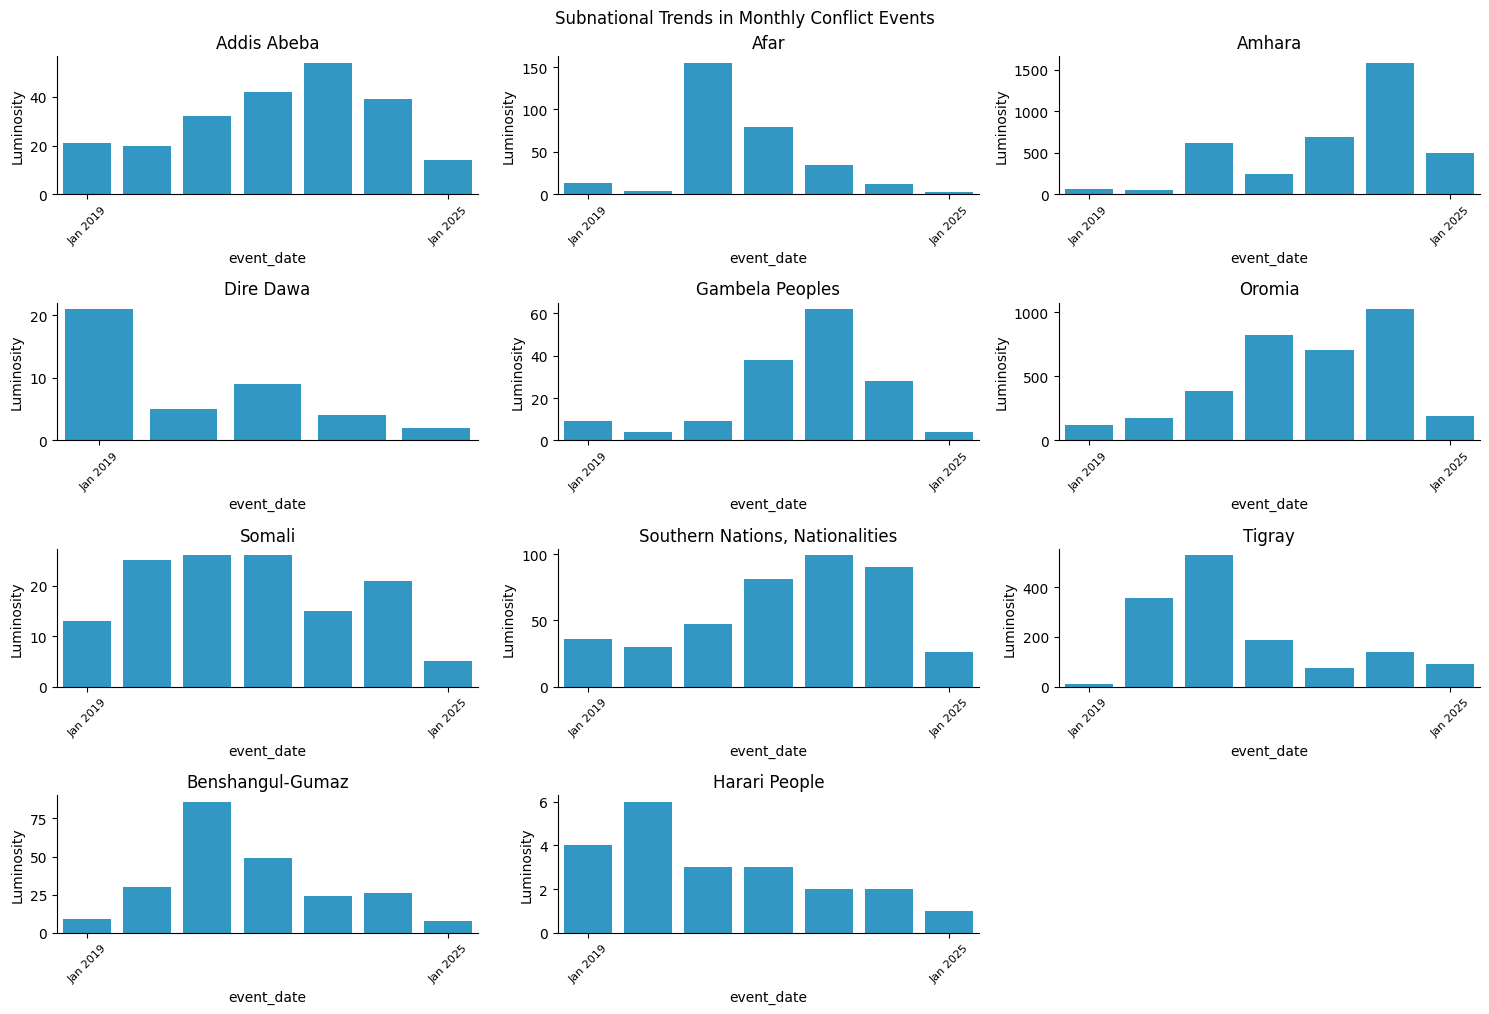

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, axes = plt.subplots(4, 3, figsize=(15, 10))  # 4x3 grid (extra space for alignment)
axes = axes.flatten()

# Create bar charts for each region
for i, region in enumerate(conflict_adm1_annual['NAME_1'].unique()):
    ax = axes[i]
    df = conflict_adm1_annual[conflict_adm1_annual['NAME_1']==region]
    df = df[df['event_date']>='2019-01-01']
    # df = df.set_index('date')
    df.loc[:, 'year'] = pd.to_datetime(df['event_date']).dt.year

    sns.barplot(data=df, x='event_date', y='nrEvents', color='#1AA1DB', ax=ax)
    ax.set_title(region)
    #ax.set_xlabel('Date')
    ax.set_ylabel('Luminosity')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    tick_positions = range(0, len(df['event_date']), 6)  # Every 6th month
    tick_labels = pd.to_datetime(df['event_date']).iloc[tick_positions].dt.strftime('%b %Y')  # Format as 'Month Year'
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=8)

#Hide extra subplots if regions < grid cells
for j in range(len(conflict_adm1_annual['NAME_1'].unique()), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.suptitle('Subnational Trends in Monthly Conflict Events', x=0.5, y=1.01)
plt.show()

#
# plt.savefig('../../docs/images/ntl_admin1_monthly.png')

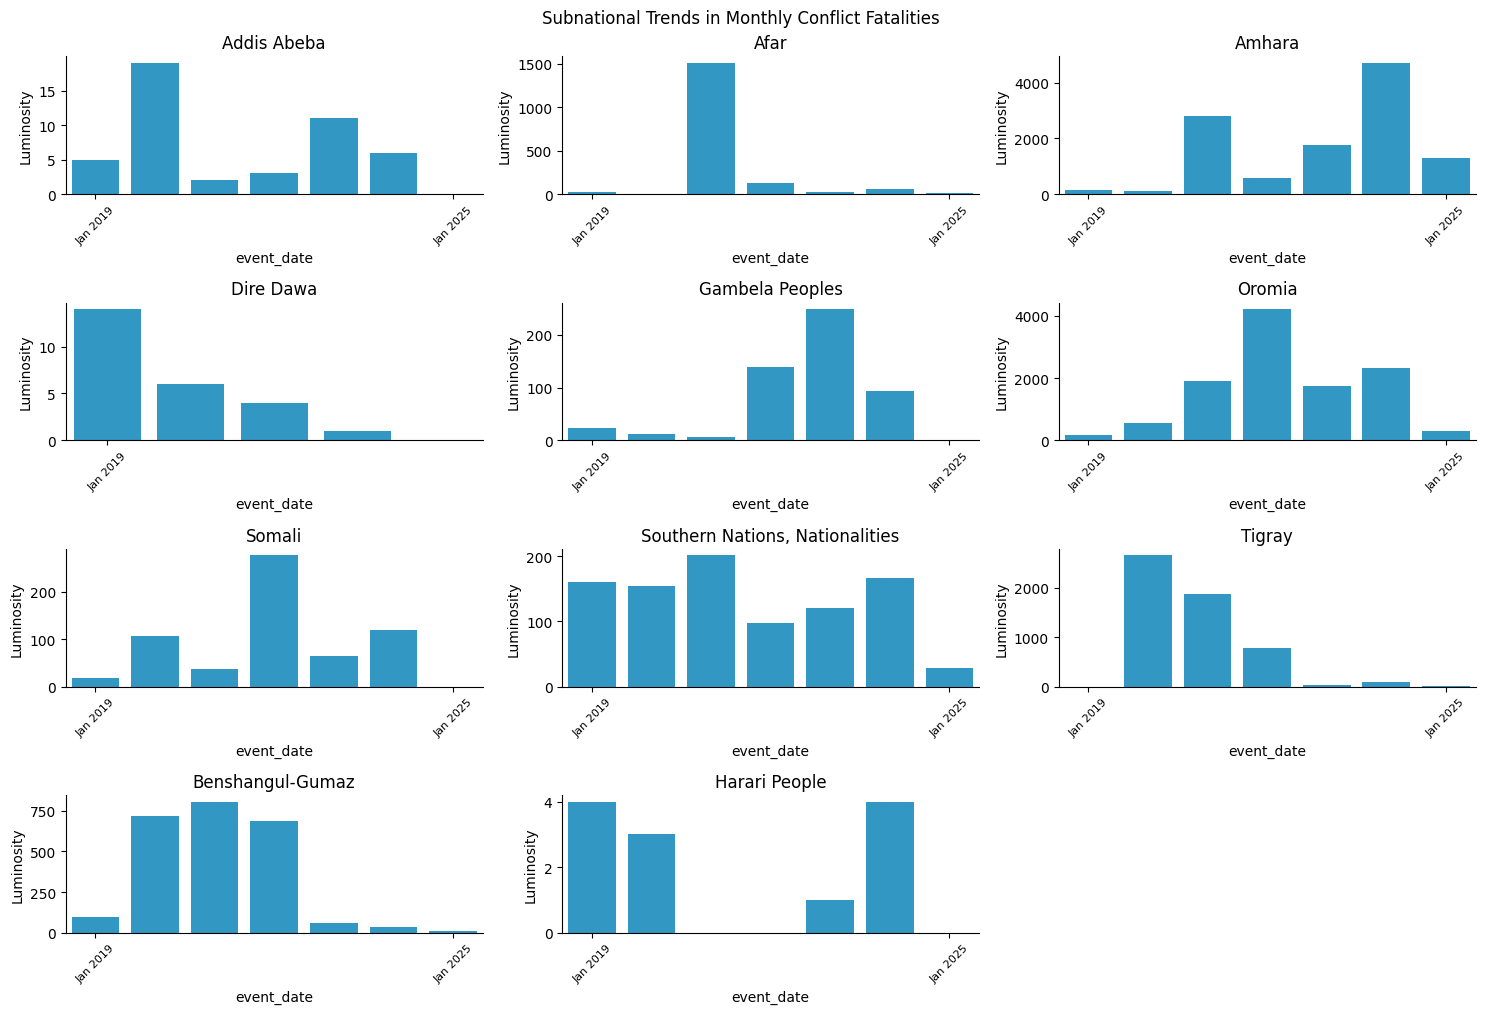

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(4, 3, figsize=(15, 10))  # 4x3 grid (extra space for alignment)
axes = axes.flatten()

# Create bar charts for each region
for i, region in enumerate(conflict_adm1_annual['NAME_1'].unique()):
    ax = axes[i]
    df = conflict_adm1_annual[conflict_adm1_annual['NAME_1']==region]
    df = df[df['event_date']>='2019-01-01']
    # df = df.set_index('date')
    df.loc[:, 'year'] = pd.to_datetime(df['event_date']).dt.year

    sns.barplot(data=df, x='event_date', y='nrFatalities', color='#1AA1DB', ax=ax)
    ax.set_title(region)
    #ax.set_xlabel('Date')
    ax.set_ylabel('Luminosity')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    tick_positions = range(0, len(df['event_date']), 6)  # Every 6th month
    tick_labels = pd.to_datetime(df['event_date']).iloc[tick_positions].dt.strftime('%b %Y')  # Format as 'Month Year'
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=8)

#Hide extra subplots if regions < grid cells
for j in range(len(conflict_adm1_annual['NAME_1'].unique()), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.suptitle('Subnational Trends in Monthly Conflict Fatalities', x=0.5, y=1.01)
plt.show()

#
# plt.savefig('../../docs/images/ntl_admin1_monthly.png')